In [10]:
import lightgbm as lgb
import optuna.visualization as vis

import numpy as np
import optuna
import sys
import joblib
import pandas as pd
import json
import matplotlib.pyplot as plt
import matplotlib

from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import r2_score

In [11]:
import seaborn as sns

In [12]:
print("Seaborn version:", sns.__version__)
print("Matplotlib version:", matplotlib.__version__)

Seaborn version: 0.13.2
Matplotlib version: 3.10.3


In [13]:
filepath = '../../split_year_data'

### Encoding Countries

In [6]:
merged = pd.DataFrame(pd.read_pickle('../../raw_merged_data_v2_withinyears'))
missing_dropped = merged.dropna(axis=1, how='all', ignore_index=True)
rdrop = missing_dropped.dropna(axis=0, how='all', ignore_index=True)
ydrop = missing_dropped.dropna(subset=['Maternal mortality ratio (national estimate, per 100,000 live births)'])

In [7]:
ydrop = ydrop[ydrop['date'] < 2019]

In [8]:
countries = ydrop['setting'].unique()
countries_dict = {}
count = 0
for c in countries:
    countries_dict[c] = count
    count += 1

In [9]:
import pickle 

with open('../../split_year_data/countries_dict.pkl', 'wb') as f:
    pickle.dump(countries_dict, f)

### Loading Datasets

In [14]:
test_data_x = pd.read_csv(filepath + '/test/X_test.csv')
test_data_x = test_data_x.drop(columns=['Unnamed: 0'], axis=1)
test_data_y = pd.read_csv(filepath + '/test/y_test.csv')
test_data_y = test_data_y.drop(columns=['Unnamed: 0'], axis=1)

In [15]:
validation = {}
for fold in range(0, 5):
    vdata_x = pd.read_csv(filepath + '/val/X_val_' + str(fold) + '.csv')
    vdata_x = vdata_x.drop(columns=['Unnamed: 0'], axis=1)
    vdata_y = pd.read_csv(filepath + '/val/y_val_' + str(fold) + '.csv')
    vdata_y = vdata_y.drop(columns=['Unnamed: 0'], axis=1)
    validation[fold] = [vdata_x, vdata_y]

In [16]:
train = {}
for fold in range(0, 5):
    tdata_x85 = pd.read_csv(filepath + '/train/X_train_' + str(fold) + '_85.csv')
    tdata_x85 = tdata_x85.drop(columns=['Unnamed: 0'], axis=1)
    tdata_y85 = pd.read_csv(filepath + '/train/y_train_' + str(fold) + '_85.csv')
    tdata_y85 = tdata_y85.drop(columns=['Unnamed: 0'], axis=1)

    tdata_x95 = pd.read_csv(filepath + '/train/X_train_' + str(fold) + '_95.csv')
    tdata_x95 = tdata_x95.drop(columns=['Unnamed: 0'], axis=1)
    tdata_y95 = pd.read_csv(filepath + '/train/y_train_' + str(fold) + '_95.csv')
    tdata_y95 = tdata_y95.drop(columns=['Unnamed: 0'], axis=1)

    tdata_x1 = pd.read_csv(filepath + '/train/X_train_' + str(fold) + '_1.csv')
    tdata_x1 = tdata_x1.drop(columns=['Unnamed: 0'], axis=1)
    tdata_y1 = pd.read_csv(filepath + '/train/y_train_' + str(fold) + '_1.csv')
    tdata_y1 = tdata_y1.drop(columns=['Unnamed: 0'], axis=1)

    train[fold] = [tdata_x85, tdata_y85, tdata_x95, tdata_y95, tdata_x1, tdata_y1]

### Objective Function

In [17]:
def objective(trial, x_train, y_train, x_val, y_val):

    n_trees = trial.suggest_int("number_trees", 10, 300)

    max_depth = trial.suggest_int("max_tree_depth", 3, 25)

    boosting_type = trial.suggest_categorical("boosting_type", ['gbdt', 'dart'])
    
    bagging_fraction = trial.suggest_float("bagging_fraction", 0.1, 1.0)
    bagging_freq = trial.suggest_int("bagging_freq", 0, 10)

    learning_rate = trial.suggest_float("learning_rate", 0, 1)
    l1_norm = trial.suggest_float("l1_norm", 0, 0.001)
    l2_norm = trial.suggest_float("l2_norm", 0, 0.001)

    lgbm_model = lgb.LGBMRegressor(random_state=42, verbosity = -1, n_estimators=n_trees, boosting=boosting_type, max_depth=max_depth, learning_rate=learning_rate, reg_alpha=l1_norm, reg_lambda=l2_norm, bagging_fraction=bagging_fraction, bagging_freq=bagging_freq)
    trained_model = lgbm_model.fit(x_train, y_train)
    y_pred = trained_model.predict(x_val)
    val_loss = mean_squared_error(y_pred, y_val)

    return val_loss  # Optuna minimizes this

### Model Iteration

#### Code Design

#### Code Implementation

In [18]:
output_dir = '../../split_year_models/lightgbm'

In [19]:
#because lightgbm cannot handle the comma
test_data_y.column = 'Maternal mortality ratio (national estimate per 100000 live births)'
test_data_x['setting'] = test_data_x['setting'].astype("category")
test_data_x.columns = test_data_x.columns.str.replace(r'[\"\[\]\{\}\\:,]', '', regex=True)

for fold in range(0, 5):
    val_input_data = validation[fold][0].copy()
    val_input_data['setting'] = val_input_data['setting'].astype("category")
    val_input_data.columns = val_input_data.columns.str.replace(r'[\"\[\]\{\}\\:,]', '', regex=True)
    val_label = validation[fold][1].copy()
    val_label.column = 'Maternal mortality ratio (national estimate per 100000 live births)'

    for thresh_idx, thresh in enumerate(['85', '95', '1']):
        if thresh_idx != 2:
            continue
        train_input_data = train[fold][thresh_idx * 2].copy()
        train_input_data['setting'] = train_input_data['setting'].astype("category")
        train_input_data.columns = train_input_data.columns.str.replace(r'[\"\[\]\{\}\\:,]', '', regex=True)
        train_label = train[fold][thresh_idx * 2 + 1].copy()
        train_label.column = 'Maternal mortality ratio (national estimate per 100000 live births)'

        #Create a study object and optimize the objective function.
        study = optuna.create_study(direction='minimize')
        study.optimize(lambda trial: objective(trial, train_input_data, train_label, val_input_data, val_label), n_trials=300)
        best_model = lgb.LGBMRegressor(**study.best_params)
        best_model.fit(train_input_data, train_label)
        
        #save best model 
        joblib.dump(best_model, output_dir + '/best_model_' + str(fold) + '_' + thresh +  '.pkl')
        joblib.dump(study.best_params, f"{output_dir}/best_params_{fold}_{thresh}.pkl")

        # Save study for later visualization
        joblib.dump(study, f"{output_dir}/optuna_study_{fold}_{thresh}.pkl")

        summary = {
            "dataset": str(fold) + '_' + thresh,
            "fold" : fold,
            "threshold": thresh,
            "model": 'lightgbm',
            "best_params": study.best_params,
            "best_optuna_loss": study.best_value
        }

        with open(f"{output_dir}/results_{fold}_{thresh}.json", "w") as f:
            json.dump(summary, f, indent=2)

[I 2025-07-25 15:21:29,278] A new study created in memory with name: no-name-27550fdd-47cf-46ca-be4d-54489b37501d
[I 2025-07-25 15:21:31,125] Trial 0 finished with value: 3165.891200482377 and parameters: {'number_trees': 101, 'max_tree_depth': 18, 'boosting_type': 'gbdt', 'bagging_fraction': 0.28332923107499525, 'bagging_freq': 1, 'learning_rate': 0.055515514669711497, 'l1_norm': 0.0008169367088011497, 'l2_norm': 0.0004686387895418203}. Best is trial 0 with value: 3165.891200482377.
[I 2025-07-25 15:21:32,636] Trial 1 finished with value: 98645.97772419233 and parameters: {'number_trees': 122, 'max_tree_depth': 19, 'boosting_type': 'gbdt', 'bagging_fraction': 0.20317600879155795, 'bagging_freq': 6, 'learning_rate': 0.881052456631398, 'l1_norm': 0.0006591802296996194, 'l2_norm': 3.3697497288782686e-06}. Best is trial 0 with value: 3165.891200482377.
[I 2025-07-25 15:21:32,899] Trial 2 finished with value: 3527.5287665144197 and parameters: {'number_trees': 50, 'max_tree_depth': 4, 'boo

Now looking at instances where data has been dropped due to the missing data thresholds

In [20]:
#because lightgbm cannot handle the comma
test_data_y.column = 'Maternal mortality ratio (national estimate per 100000 live births)'
test_data_x['setting'] = test_data_x['setting'].astype("category")
test_data_x.columns = test_data_x.columns.str.replace(r'[\"\[\]\{\}\\:,]', '', regex=True)

for fold in range(0, 5):
    val_input_data = validation[fold][0].copy()
    val_input_data['setting'] = val_input_data['setting'].astype("category")
    val_input_data.columns = val_input_data.columns.str.replace(r'[\"\[\]\{\}\\:,]', '', regex=True)
    val_label = validation[fold][1].copy()
    val_label.column = 'Maternal mortality ratio (national estimate per 100000 live births)'

    for thresh_idx, thresh in enumerate(['85', '95', '1']):
        if thresh_idx == 2:
            continue

        train_input_data = train[fold][thresh_idx * 2].copy()
        train_input_data['setting'] = train_input_data['setting'].astype("category")
        train_input_data.columns = train_input_data.columns.str.replace(r'[\"\[\]\{\}\\:,]', '', regex=True)
        train_label = train[fold][thresh_idx * 2 + 1].copy()
        train_label.column = 'Maternal mortality ratio (national estimate per 100000 live births)'

        columns_needed = val_input_data.columns.intersection(train_input_data.columns)
        val_relevant_input = val_input_data[columns_needed]

        #Create a study object and optimize the objective function.
        study = optuna.create_study(direction='minimize')
        study.optimize(lambda trial: objective(trial, train_input_data, train_label, val_relevant_input, val_label), n_trials=300)
        best_model = lgb.LGBMRegressor(**study.best_params)
        best_model.fit(train_input_data, train_label)
        
        #save best model 
        joblib.dump(best_model, output_dir + '/best_model_' + str(fold) + '_' + thresh +  '.pkl')
        joblib.dump(study.best_params, f"{output_dir}/best_params_{fold}_{thresh}.pkl")

        # Save study for later visualization
        joblib.dump(study, f"{output_dir}/optuna_study_{fold}_{thresh}.pkl")

        summary = {
            "dataset": str(fold) + '_' + thresh,
            "fold" : fold,
            "threshold": thresh,
            "model": 'lightgbm',
            "best_params": study.best_params,
            "best_optuna_loss": study.best_value
        }

        with open(f"{output_dir}/results_{fold}_{thresh}.json", "w") as f:
            json.dump(summary, f, indent=2)

[I 2025-07-25 16:21:16,329] A new study created in memory with name: no-name-f48112a6-e043-47f3-a89e-c09c85abad40
[I 2025-07-25 16:21:16,768] Trial 0 finished with value: 10313.634603177827 and parameters: {'number_trees': 78, 'max_tree_depth': 7, 'boosting_type': 'dart', 'bagging_fraction': 0.3911525737590726, 'bagging_freq': 0, 'learning_rate': 0.4638202225669069, 'l1_norm': 0.000831396109474422, 'l2_norm': 0.00029207046049198814}. Best is trial 0 with value: 10313.634603177827.
[I 2025-07-25 16:21:19,416] Trial 1 finished with value: 17051.42047766585 and parameters: {'number_trees': 203, 'max_tree_depth': 13, 'boosting_type': 'gbdt', 'bagging_fraction': 0.527327872034559, 'bagging_freq': 6, 'learning_rate': 0.4971197795717607, 'l1_norm': 0.0005852799642617363, 'l2_norm': 0.0005556569522485459}. Best is trial 0 with value: 10313.634603177827.
[I 2025-07-25 16:21:19,546] Trial 2 finished with value: 15159.887776223828 and parameters: {'number_trees': 18, 'max_tree_depth': 5, 'boostin

### Loading Models

In [21]:
output_dir = '../../split_year_models/lightgbm'

#### Test values for all models

In [22]:
# setting up the dataframe to hold test results
index = pd.MultiIndex.from_tuples(
    [('Threshold 85%', '1'), ('Threshold 85%', '2'), ('Threshold 85%', '3'), ('Threshold 85%', '4'), ('Threshold 85%', '5'),
     ('Threshold 95%', '1'), ('Threshold 95%', '2'), ('Threshold 95%', '3'), ('Threshold 95%', '4'), ('Threshold 95%', '5'),
     ('None', '1'), ('None', '2'), ('None', '3'), ('None', '4'), ('None', '5')],
    names=['Missing Data Threshold', 'Fold']
)
test_stats = pd.DataFrame(index=index, columns=['MAPE', 'MAE', 'MSE', 'RMSE', 'R2'])

test_stats

MAPE  MAE  MSE RMSE   R2
Missing Data Threshold Fold                         
Threshold 85%          1     NaN  NaN  NaN  NaN  NaN
                       2     NaN  NaN  NaN  NaN  NaN
                       3     NaN  NaN  NaN  NaN  NaN
                       4     NaN  NaN  NaN  NaN  NaN
                       5     NaN  NaN  NaN  NaN  NaN
Threshold 95%          1     NaN  NaN  NaN  NaN  NaN
                       2     NaN  NaN  NaN  NaN  NaN
                       3     NaN  NaN  NaN  NaN  NaN
                       4     NaN  NaN  NaN  NaN  NaN
                       5     NaN  NaN  NaN  NaN  NaN
None                   1     NaN  NaN  NaN  NaN  NaN
                       2     NaN  NaN  NaN  NaN  NaN
                       3     NaN  NaN  NaN  NaN  NaN
                       4     NaN  NaN  NaN  NaN  NaN
                       5     NaN  NaN  NaN  NaN  NaN

In [23]:
test_data_y.iloc[0] + 5

Maternal mortality ratio (national estimate, per 100,000 live births)    456.0
Name: 0, dtype: float64

In [24]:
best_parameters = {'Threshold 85%' : [], 'Threshold 95%' : [], 'None' : []}

In [25]:
test_data_x['setting'] = test_data_x['setting'].astype("category")
testing_x = test_data_x.copy()
testing_x.columns = testing_x.columns.str.replace(r'[\"\[\]\{\}\\:,]', '', regex=True)

for fold, fold_num in enumerate(['1', '2', '3', '4', '5']):
    for thresh, thresh_name in enumerate(['Threshold 85%', 'Threshold 95%', 'None']):
        
        if thresh == 0:
            name = '85'
        elif thresh == 1:
            name = '95'
        else: name = '1'

        best_params = joblib.load(f"{output_dir}/best_params_{fold}_{name}.pkl")
        best_parameters[thresh_name].append(best_params)
        best_model = joblib.load(f"{output_dir}/best_params_{fold}_{name}.pkl")

        train_input_data = train[fold][thresh * 2].copy()
        train_input_data['setting'] = train_input_data['setting'].astype("category")
        train_input_data.columns = train_input_data.columns.str.replace(r'[\"\[\]\{\}\\:,]', '', regex=True)

        train_label = train[fold][thresh * 2 + 1].copy()
        train_label.column = 'Maternal mortality ratio (national estimate per 100000 live births)'

        columns_needed = testing_x.columns.intersection(train_input_data.columns)
        to_test = testing_x[columns_needed].copy()

        loaded_model = lgb.LGBMRegressor(**best_params, verbosity = -1)
        train_load = loaded_model.fit(train_input_data, train_label)
        prediction = train_load.predict(to_test)
        mse = mean_squared_error(prediction, test_data_y)
        mae = mean_absolute_error(prediction, test_data_y)
        rmse = np.sqrt(mse)
        r2 = r2_score(prediction, test_data_y)

        #to calculate mape
        num_predictions = len(prediction)
        mape = 0
        for p in range(0, num_predictions):
            mape += np.abs(prediction[p] - test_data_y.iloc[p]) / np.maximum(np.abs(prediction[p]), np.abs(test_data_y.iloc[p]))
        mape = mape/num_predictions
        #mape = (1/num_predictions) * np.sum(np.abs(prediction - test_data_y) / np.max(np.abs(prediction), np.abs(test_data_y)))

        test_stats.loc[(thresh_name, fold_num), 'MSE'] = mse
        test_stats.loc[(thresh_name, fold_num), 'MAE'] = mae
        test_stats.loc[(thresh_name, fold_num), 'RMSE'] = rmse
        test_stats.loc[(thresh_name, fold_num), 'R2'] = r2
        test_stats.loc[(thresh_name, fold_num), 'MAPE'] = mape[0]
        

/var/folders/jd/0gmk2m5x1cl2hh0v_hsx43q40000gn/T/ipykernel_11376/836377741.py:48: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  test_stats.loc[(thresh_name, fold_num), 'MAPE'] = mape[0]
/var/folders/jd/0gmk2m5x1cl2hh0v_hsx43q40000gn/T/ipykernel_11376/836377741.py:48: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  test_stats.loc[(thresh_name, fold_num), 'MAPE'] = mape[0]
/var/folders/jd/0gmk2m5x1cl2hh0v_hsx43q40000gn/T/ipykernel_11376/836377741.py:48: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame 

In [26]:
test_stats

MAPE        MAE          MSE       RMSE  \
Missing Data Threshold Fold                                                
Threshold 85%          1     0.439655  28.876144  7718.743596  87.856381   
                       2     0.461794  26.117934  6052.166989  77.795675   
                       3     0.533841  33.509011  6652.491625  81.562808   
                       4     0.450432   29.61678  7455.530168  86.345412   
                       5     0.601137  37.560082  8391.703733  91.606243   
Threshold 95%          1     0.417752  28.305152  6380.033252   79.87511   
                       2     0.371412   25.52453   6178.32393  78.602315   
                       3     0.421766  25.328288  5483.072704  74.047773   
                       4     0.367073  23.467991  5008.189342  70.768562   
                       5     0.406498  24.875721    5314.6529  72.901666   
None                   1     0.403196  25.871494  5961.165097  77.208582   
                       2     0.593242  33.476754  5990.616008   77.39907   
                       3     0.495355  32.908636  6524.867527  80.776652   
                       4     0.400529  27.520976   5755.92203  75.867793   
                       5     0.466129  28.421179  5494.842783  74.127207   

                                   R2  
Missing Data Threshold Fold            
Threshold 85%          1     0.396796  
                       2      0.66463  
                       3     0.710519  
                       4     0.495914  
                       5     0.683518  
Threshold 95%          1     0.621962  
                       2     0.645735  
                       3     0.738377  
                       4     0.776743  
                       5     0.748868  
None                   1      0.65743  
                       2     0.723022  
                       3     0.671905  
                       4     0.730986  
                       5     0.777203

In [27]:
mean_summary = test_stats.groupby(level='Missing Data Threshold').mean()
mean_summary = mean_summary.astype('float')
mean_summary = mean_summary.round(2)
std_summary = test_stats.groupby(level='Missing Data Threshold').std()
std_summary = std_summary.astype('float')
std_summary = std_summary.round(2)

In [28]:
# setting up the dataframe to hold summary of cross-fold validation results
summary_index = pd.MultiIndex.from_tuples(
    [('Threshold 85%', '1'), ('Threshold 85%', '2'), ('Threshold 85%', '3'), ('Threshold 85%', '4'), ('Threshold 85%', '5'),
     ('Threshold 95%', '1'), ('Threshold 95%', '2'), ('Threshold 95%', '3'), ('Threshold 95%', '4'), ('Threshold 95%', '5'),
     ('None', '1'), ('None', '2'), ('None', '3'), ('None', '4'), ('None', '5')],
    names=['Missing Data Threshold', 'Fold']
)

summary_stats = pd.DataFrame(index=['Threshold 85%', 'Threshold 95%', 'None'], columns=['MAPE', 'MAE', 'MSE', 'RMSE', 'R2'])

for thresh_idx, thresh in enumerate(['Threshold 85%', 'Threshold 95%', 'None']):
    for metric_idx, metric in enumerate(['MAPE', 'MAE', 'MSE', 'RMSE', 'R2']):
        summary_stats.iloc[thresh_idx][metric_idx] = str(mean_summary.iloc[thresh_idx][metric_idx]) + ' +- ' + str(std_summary.iloc[thresh_idx][metric_idx])

summary_stats

/var/folders/jd/0gmk2m5x1cl2hh0v_hsx43q40000gn/T/ipykernel_11376/2971279602.py:13: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  summary_stats.iloc[thresh_idx][metric_idx] = str(mean_summary.iloc[thresh_idx][metric_idx]) + ' +- ' + str(std_summary.iloc[thresh_idx][metric_idx])
/var/folders/jd/0gmk2m5x1cl2hh0v_hsx43q40000gn/T/ipykernel_11376/2971279602.py:13: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  summary_stats.iloc[thresh_idx][metric_idx] = str(mean_summary.iloc[thresh_idx][metric_idx]) + ' +- ' + str(std_summary.iloc[thresh_idx][metric_idx])


,MAPE,MAE,MSE,RMSE,R2
Threshold 85%,0.47 +- 0.08,29.64 +- 3.38,5945.48 +- 379.8,77.08 +- 2.45,0.71 +- 0.05
Threshold 95%,0.5 +- 0.07,31.14 +- 4.46,7254.13 +- 916.13,85.03 +- 5.42,0.59 +- 0.14
None,0.4 +- 0.03,25.5 +- 1.76,5672.85 +- 583.46,75.24 +- 3.86,0.71 +- 0.07


#### Best Parameters

#### Visualisation

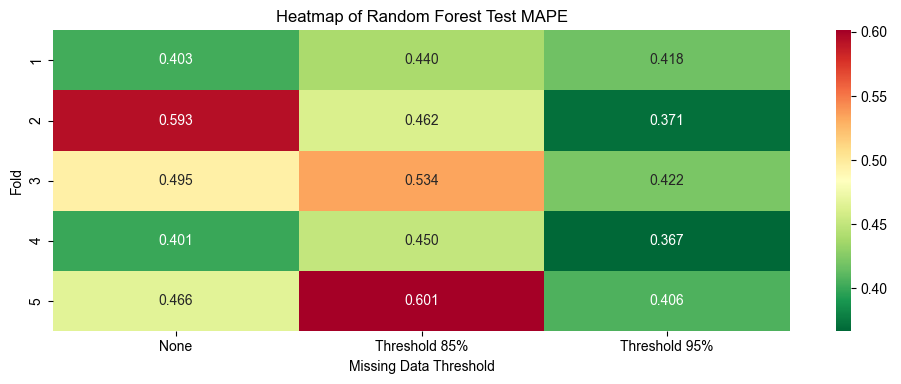

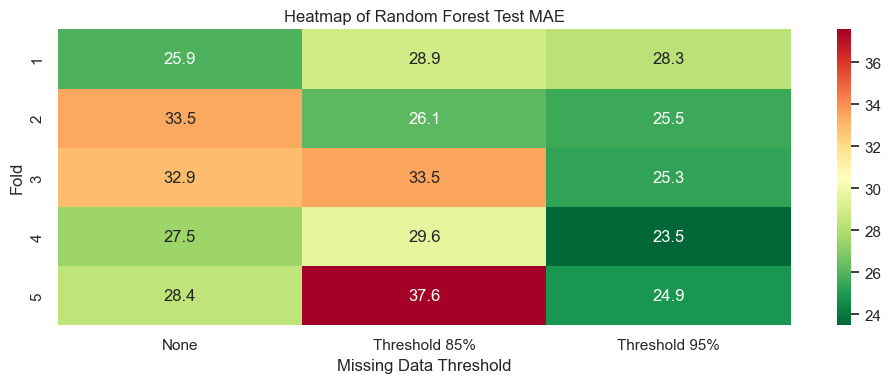

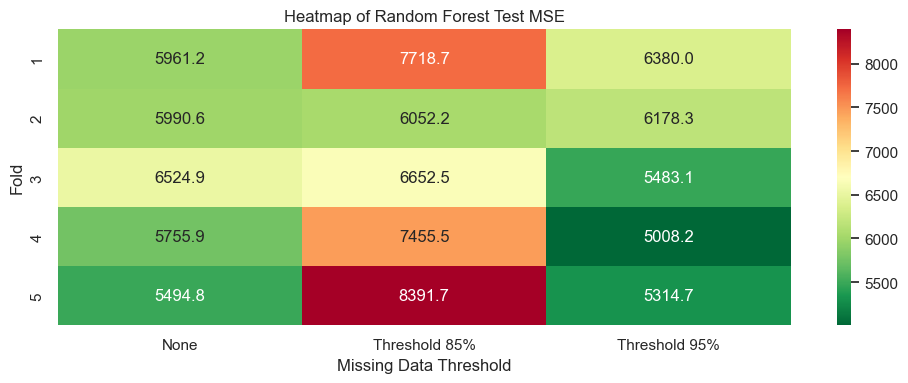

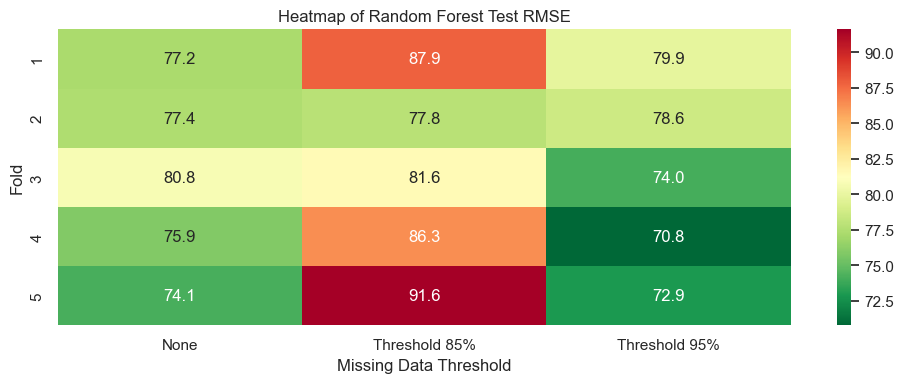

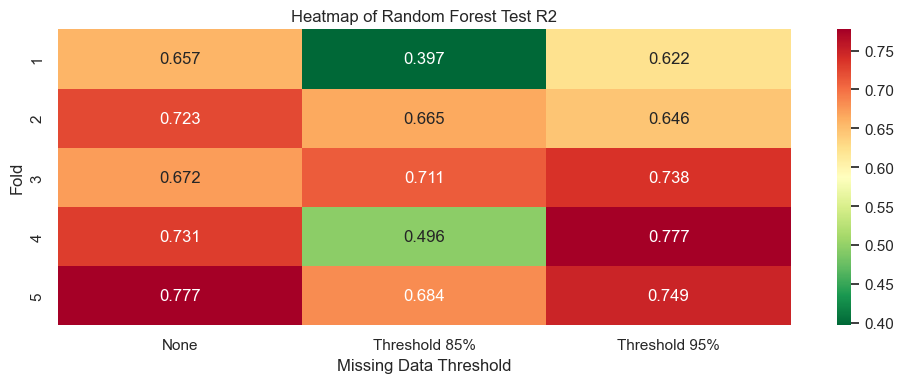

In [29]:
import seaborn as sns

data = test_stats.astype(float)

for metric in data.columns:
    plt.figure(figsize=(10, 4))
    d = pd.DataFrame(data[metric].unstack(level='Missing Data Threshold'))
    if metric == 'MAPE' or metric == 'R2':
        fmt = ".3f"
    else:
        fmt = ".1f"
    sns.heatmap(d, annot=True, fmt=fmt, cmap="RdYlGn_r", cbar=True)
    sns.set_theme(context='notebook', style='whitegrid')  # or 'paper'
    plt.title("Heatmap of Random Forest Test " + metric)
    plt.xlabel("Missing Data Threshold")
    plt.ylabel("Fold")
    plt.tight_layout()
    plt.show()

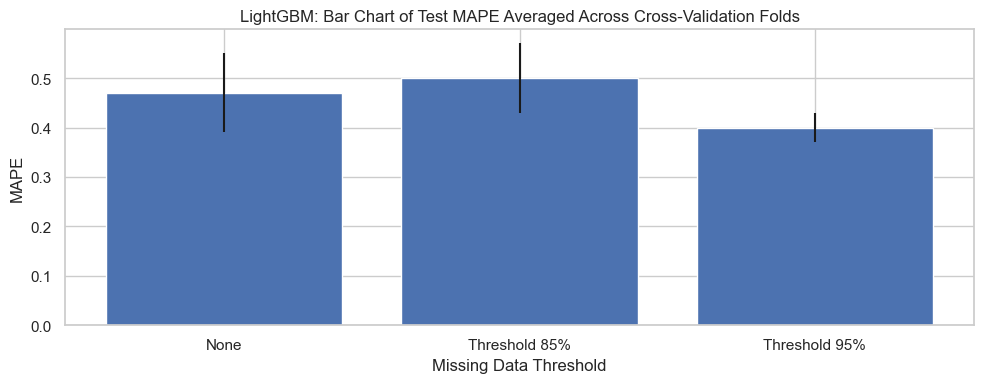

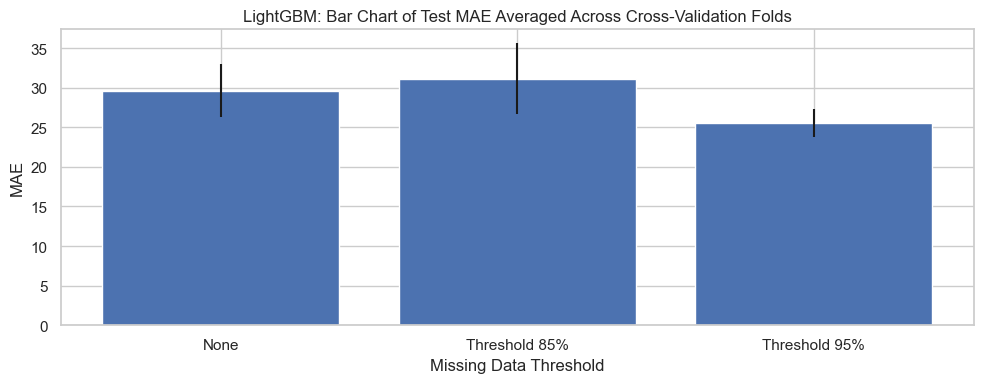

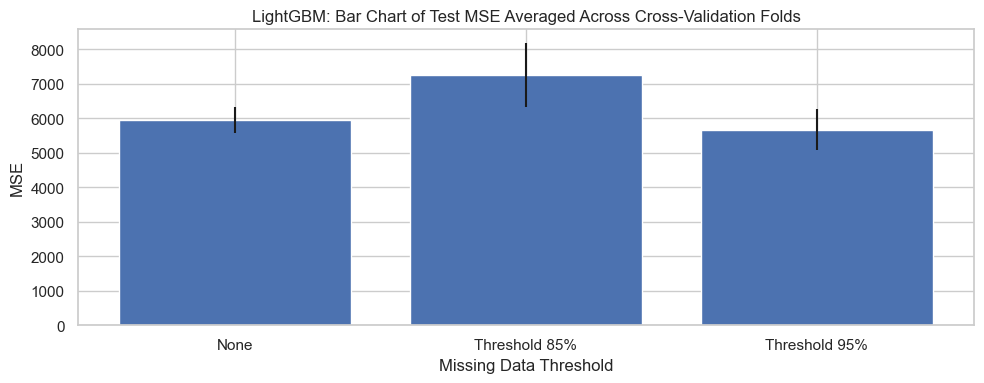

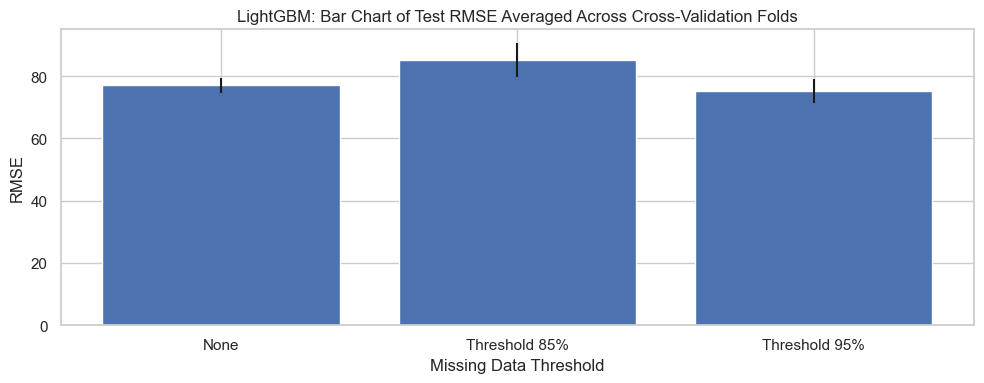

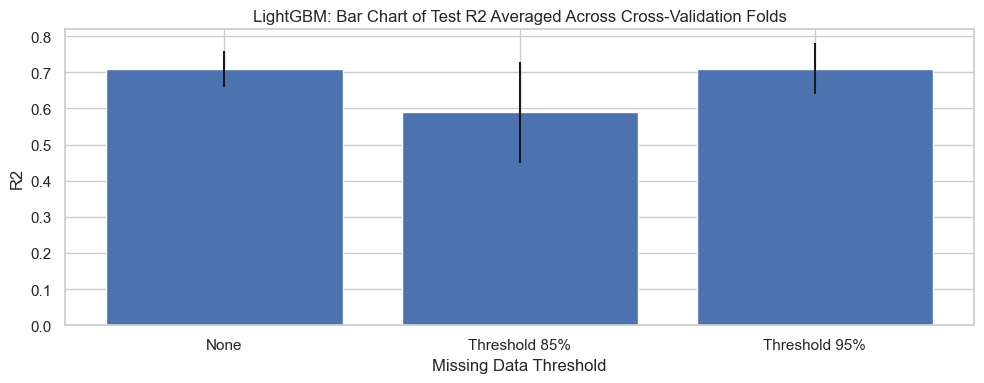

In [30]:
mean_data = mean_summary.astype(float)
std_data = std_summary.astype(float)

for metric in mean_data.columns:
    plt.figure(figsize=(10, 4))
    d_full = mean_data[metric]
    d = mean_data[metric].values
    e = std_data[metric].values
    plt.bar(d_full.index, d, yerr = e)
    plt.title("LightGBM: Bar Chart of Test " + metric + " Averaged Across Cross-Validation Folds")
    plt.xlabel("Missing Data Threshold")
    plt.ylabel(metric)
    plt.tight_layout()
    plt.show()

In [31]:
mean_corr = mean_summary.corr()
mean_corr

,MAPE,MAE,MSE,RMSE,R2
MAPE,1.000000,0.999316,0.831723,0.840383,-0.731307
MAE,0.999316,1.000000,0.810626,0.819768,-0.705589
MSE,0.831723,0.810626,1.000000,0.999875,-0.986912
RMSE,0.840383,0.819768,0.999875,1.000000,-0.984243
R2,-0.731307,-0.705589,-0.986912,-0.984243,1.000000


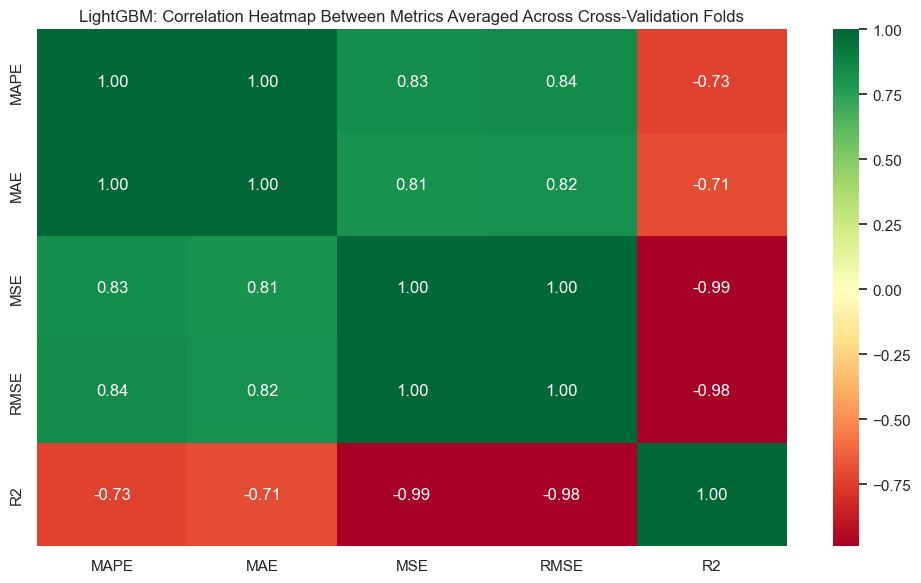

In [32]:
plt.figure(figsize=(10, 6))
sns.heatmap(mean_corr, annot=True, fmt=".2f", cmap="RdYlGn", center=0)
plt.title("LightGBM: Correlation Heatmap Between Metrics Averaged Across Cross-Validation Folds")
plt.tight_layout()
plt.show()

### extras